# Part 1a - Converting Video to Frames

In [ ]:
import cv2
import numpy as np
import os

In [ ]:
#From video to images
def convertVidToFrames(pathIn, pathOut):
    vidcap = cv2.VideoCapture(os.path.abspath(pathIn))
    success,image = vidcap.read()
    count = 0
    while success:
      cv2.imwrite(os.path.join(os.path.abspath(pathOut),"frame%d.jpg" % count), image)     # save frame as JPEG file      
      success,image = vidcap.read()
    #   print('Read a new frame: ', success)
      count += 1

### Input the video path and output path

In [ ]:
Vidpath = "cute.mp4"
pathout = "result"
convertVidToFrames(Vidpath, pathout)

# Part 1b - Convert Frames to Video

In [ ]:
from os.path import isfile, join
 
def convert_frames_to_video(pathIn,pathOut,fps):
    pathIn = os.path.abspath(pathIn)
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
 
    for i in range(len(files)):
        filename=os.path.join(pathIn,files[i])
        #reading each files
        img = cv2.imread(filename)
#         cv2.imshow('image',img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        height, width, layers = img.shape
#         print(img.shape)
        size = (width,height)
#         print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
#     print(pathOut)
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        out.write(frame_array[i])
#     print("hello")
    out.release()
    cv2.destroyAllWindows()

### Input the frames location and output file name (saves the video in the current working dir)

In [ ]:
pathIn= 'result'
pathOut = os.path.join(os.getcwd(),'out.mp4')
fps = 25.0
convert_frames_to_video(pathIn, pathOut, fps)

# Part 2 - Clicking images from webcam

In [ ]:
import cv2

cam = cv2.VideoCapture(0)
cv2.namedWindow("clickImage")
img_counter = 0

while True:
    ret, frame = cam.read()
    cv2.imshow("clickImage", frame)
    if not ret:
        break
    press_key = cv2.waitKey(1)

    if press_key == 27:
        break
    elif press_key == 32:
        img = "Pic_{0}.JPEG".format(img_counter)
        cv2.imwrite(img, frame)
        print("{0} written!".format(img))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

# Part 3 - Chroma Keying

### Problem: Merge two videos, one with a foreground object and another with background(Green Screen)
### Solution: 
1. Check the pixels where green color is dominant and change the intensitiy (alpha) to zero, rest where the actual foreground object is present, change the intensity to 255(MAX)
2. Merge the above filtered object onto the background image and set the relevant pixels(pixels where intensity of foreground(alpha) = 255 to those of the object background
3. Follow the above process for each set of frames from foreground and background and write them to a file

### Challenges:
1. While checking for pixels where green is dominant, taking difference on pixel values casues an issue as the datatype is uint. Dividing it by 1 changes it to float
2. cv2.imread() - reads the image in RGB format, had to convert it to RGBA format
3. Since the at the object boundaries, the pixel density dilutes, had to play around with the threshold above which the pixel would be considered as that of the foreground object
4. While merging videos, since the length of both the videos might not be same, had to loop the background video
5. While saving videos, many times the file was not getting created, if the the dimensions given differ.

### Learnings:
1. Learn how to work with images and videos with openCV
2. Learn about what an image is (formats, pixels, etc)
3. Learn about Chroma Keying, and how to do it using openCV

In [1]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.misc import imread

## Checking 

In [2]:
#check shapes read from iread
foreground = imread('girl.jpg', mode ='RGBA')
background = imread('background.jpeg', mode ='RGBA')
print(foreground.shape, background.shape)


(960, 640, 4) (178, 284, 4)


/home/aman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/aman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


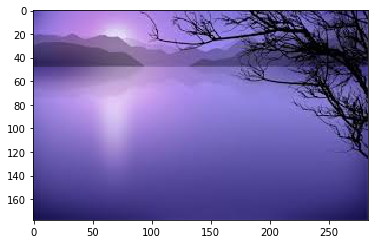

In [3]:
#plotting the images
plt.imshow(foreground)
plt.imshow(background)

In [4]:
#filering the green color
def filterBackGround(image):
    #converting from uint to float, to handle negative values
    red_layer = image[:,:,0]/1
    green_layer = image[:,:,1]/1
    blue_layer = image[:,:,2]/1
    
    red_diff_green = red_layer - green_layer + 50
    blue_diff_green = blue_layer - green_layer + 50
    
    red_diff_green[red_diff_green < 0] = 0
    blue_diff_green[blue_diff_green < 0] = 0
    
    alpha = red_diff_green + blue_diff_green
    alpha[alpha > 30] = 255
    alpha[alpha <= 30] = 0
    
    image[:,:,3] = alpha
    return image

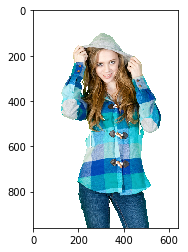

In [5]:
img = filterBackGround(foreground)
plt.imshow(img)

In [6]:
def merge(foreground, background, x_offset=0, y_offset=0):
    (y_size, x_size, _) = foreground.shape
    crop_start_x = x_offset
    crop_end_x = crop_start_x + x_size
    crop_start_y = y_offset
    crop_end_y = crop_start_y + y_size
    bg_cropped = background[crop_start_y:crop_end_y,
                           crop_start_x:crop_end_x,
                           :]
    foreground_pixels = (foreground[:,:,-1] > 10)
#     print(bg_cropped.shape, foreground.shape, foreground_pixels.shape)
    bg_cropped[foreground_pixels] = foreground[foreground_pixels]
    background[crop_start_y:crop_end_y,
                crop_start_x:crop_end_x,
                :] = bg_cropped
    return background

In [7]:
def rgb2rgba(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)

In [12]:
from os.path import isfile, join
 
def mergeVideos(foreground_path, background_path, pathOut):
    foreground_path = os.path.abspath(foreground_path)
    background_path = os.path.abspath(background_path)
    print(foreground_path, background_path)
    pathOut = os.path.abspath(pathOut)
    print(pathOut)
    #storing output frames
    frame_array = []
    front = cv2.VideoCapture(foreground_path)
    back = cv2.VideoCapture(background_path)
    front_ret = True
    count = 0;
    fps = 20;
    cnt = 0
    while(front.isOpened()):
        count += 1
        if count == back.get(cv2.CAP_PROP_FRAME_COUNT):
            count = 0 #Or whatever as long as it is the same as next line
            back = cv2.VideoCapture(background_path)
        front_ret, front_frame = front.read()
        if(not front_ret):
            break;
        back_ret, back_frame = back.read()
        front_frame = rgb2rgba(front_frame)
        back_frame = rgb2rgba(back_frame)
        (height, width, _) = back_frame.shape
        
        if cnt == 240:
            cv2.imwrite('fg_image_p.jpg', front_frame)
            cv2.imwrite('bg_image_p.jpg', back_frame)
        
        size = (width,height)
        front_filtered = filterBackGround(front_frame)
        merged_img = merge(front_filtered, back_frame)
        cv2.imshow('frame',merged_img)
        if cnt == 240:
            cv2.imwrite('merged_p.jpg', merged_img)
        if ((cv2.waitKey(1) & 0xFF == ord('q')) or (not front_ret)):
            break
        cnt+=1
            
        frame_array.append(cv2.cvtColor(merged_img, cv2.COLOR_RGBA2RGB))
    print(pathOut)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    print(fps, size)
    out = cv2.VideoWriter(pathOut,fourcc, fps, size)
    for img in frame_array:
        out.write(img)
    front.release()
    back.release()
    out.release()
    cv2.destroyAllWindows()

In [13]:
fg_video_path = "background_p.mp4"
bg_video_path = "foreground_p.mp4"
out_path = "out.mp4"
mergeVideos(fg_video_path, bg_video_path, out_path)

/home/aman/Documents/SPRING19/cv/assignment1/background_p.mp4 /home/aman/Documents/SPRING19/cv/assignment1/foreground_p.mp4
/home/aman/Documents/SPRING19/cv/assignment1/out.mp4
/home/aman/Documents/SPRING19/cv/assignment1/out.mp4
20 (1280, 720)
